# RSNA Screening Mammography Breast Cancer Detection
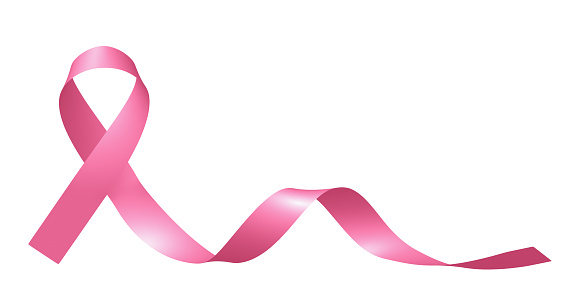

[train/test]_images/[patient_id]/[image_id].dcm The mammograms, in dicom format. You can expect roughly 8,000 patients in the hidden test set. There are usually but not always 4 images per patient. Note that many of the images use the jpeg 2000 format which may you may need special libraries to load.

**[train/test].csv** Metadata for each patient and image. Only the first few rows of the test set are available for download.

  - site_id - ID code for the source hospital.
  - patient_id - ID code for the patient.
  - image_id - ID code for the image.
  - laterality - Whether the image is of the left or right breast.
  - view - The orientation of the image. The default for a screening exam is to - capture two views per breast.
  - age - The patient's age in years.
  - implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
  - density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
  - machine_id - An ID code for the imaging device.
  - cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
  - biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
  - invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
  - BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
  - prediction_id - The ID for the matching submission row. Multiple images will share the same prediction ID. Test only.
  - difficult_negative_case - True if the case was unusually difficult. Only provided for train.

In [ ]:
# !kaggle competitions download -c rsna-breast-cancer-detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pydicom
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import plotly.express as px

import sklearn
import imblearn
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network

from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,classification_report
from sklearn.feature_selection import SelectKBest,SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

import pickle 

import os
import cv2

# !pip install pylibjpeg
# import pylibjpeg

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00


# Metadata Study

In [4]:
# Meta Data Import
Train_df=pd.read_csv('/content/drive/My Drive/CIS508/BreastCancerKaggle/train.csv')
Test_df=pd.read_csv('/content/drive/My Drive/CIS508/BreastCancerKaggle/test.csv')

In [5]:
Train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [6]:
Test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [7]:
Train_df['cancer'].value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# CNN Model Development

In [10]:
# Extracting few samples from dataset fro Training Purpose
class0=Train_df[Train_df['cancer']==0].copy()
class1=Train_df[Train_df['cancer']==1].copy()

def selectsample(class0,class1,n):
  # Class0=n
  # Class1=1158
  temp=class0.sample(n).copy()
  temp=temp.append(class1)
  return temp

# With 2000 class0 and 1158 class1 samples
Train_df_sample=selectsample(class0,class1,2000)

# Creating a dict for creating label for each image
imageid=Train_df_sample['image_id'].tolist()
cancer=Train_df_sample['cancer'].tolist()
mydict=dict(zip(imageid,cancer))

len(Train_df_sample)

3158

In [ ]:
# Using 256 x 256 png images from Kaggle
# Unzip png images and convert to a Train and Test Folder with PatientId folders and all images with name as imageid as mentioned in .csv files
# Inefficient
def create_trainset():
  training_data=[]
  currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')

# For each patient in Training Dataset
  for pat in os.listdir(os.path.join(currentdir,'train_images_processed_cv2_256')):
  #  print('Patient Folder:',pat)
    path=os.path.join(currentdir,'train_images_processed_cv2_256',pat)

    for myimage in os.listdir(path):
  #    print(' Working on Image Id : ',myimage)
      if int(myimage[:-4]) in Train_df_sample['image_id'].tolist():
        image=cv2.imread(os.path.join(path,myimage),cv2.IMREAD_GRAYSCALE)

        # plt.imshow(image,cmap='binary')
        # plt.title(str(myimage)+' '+str(mydict[ int(myimage[:-4]) ] ) )

        print('In sample')
        training_data.append([image,mydict[int(myimage[:-4])]])
        
  print('COMPLETE')
  
create_trainset()

In [ ]:
len(training_data)

In [ ]:
def featuretarget(training_data):
  IMG_PX_SIZE=256
  X=[]
  Y=[]
  for features,target in training_data:
    X.append(features)
    Y.append(target)
  X=np.array(X).reshape(-1,IMG_PX_SIZE,IMG_PX_SIZE,1)
  Y=np.array(Y)
  return X,Y

X,Y=featuretarget(training_data)

# Saving data as pickle 
import pickle 

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000.pickle'),"wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000.pickle'),"wb")
pickle.dump(Y,pickle_out)
pickle_out.close()

In [22]:
# Load pickle dataset 
X=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/X_2000.pickle'),'rb'))
Y=pickle.load(open(os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle/Y_2000.pickle'),'rb'))
len(X),len(Y)

(3158, 3158)

In [23]:
X.shape[1:]

(256, 256, 1)

In [24]:
# import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Flatten,Dense,Dropout,Activation
from keras.utils import normalize

In [25]:
model1=Sequential()

model1.add(Conv2D(64,(3,3),input_shape=X.shape[1:],activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64,(3,3),activation='relu'))
model1.add(MaxPooling2D(pool_size=(3,3)))

#Input layer
model1.add(Flatten())
#Hidden Layer
model1.add(Dense(64))
#Output Layer
model1.add(Dense(1,activation='sigmoid'))

In [26]:
X=normalize(X)

model1.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model1.fit(X,Y,batch_size=32,validation_split=0.1,verbose=1,epochs=3)

Epoch 1/3
89/89 [==============================] - 506s 6s/step - loss: 0.8750 - accuracy: 0.6277 - val_loss: 0.6668 - val_accuracy: 0.6171
Epoch 2/3
89/89 [==============================] - 460s 5s/step - loss: 0.6277 - accuracy: 0.6446 - val_loss: 0.6725 - val_accuracy: 0.6266
Epoch 3/3
89/89 [==============================] - 428s 5s/step - loss: 0.5865 - accuracy: 0.6865 - val_loss: 0.6935 - val_accuracy: 0.5665


In [27]:
model1.save('BreastDetectionBaseCNN.model')

In [29]:
# Load the pre-saved Model from Keras
model1=keras.models.load_model('BreastDetectionBaseCNN.model')

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 107584)            0         
                                                                 
 dense (Dense)               (None, 64)                6

# Validating the Test Images

In [68]:
# Data Conversion from DICOM to JPEG
import pydicom as dicom
import numpy as np
from PIL import Image
import os
from skimage.transform import resize

def convert(myimage):
    im = dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test/'+myimage)
    im = im.pixel_array.astype(float)
    IMG_PX_SIZE=256
    resized_img=resize(im,(IMG_PX_SIZE,IMG_PX_SIZE),anti_aliasing=True)

    rescaled_image = (np.maximum(resized_img,0)/resized_img.max()) * 255 # float pixel
    final_image = np.uint8(rescaled_image) # integers pixels
    final_image = Image.fromarray(final_image)
    return final_image


path="/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test"
ct_images = os.listdir(path)
arr_filename = [x for x in ct_images if x.endswith(".dcm")]

for name in arr_filename:
    image = convert(name)
    image.save('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_test/'+name[0:-4]+'.png')

In [69]:
# Create Test Set for Validation
test_set=[]
currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')
testpngimages=[i for i in os.listdir(os.path.join(currentdir,'image_test')) if i.endswith('.png')]

for myimage in testpngimages:
  image=cv2.imread(os.path.join(currentdir,'image_test',myimage),cv2.IMREAD_GRAYSCALE)
  test_set.append(image)

In [70]:
test_set[0].shape

(256, 256)

In [71]:
test_set=normalize(test_set)
predictions=model1.predict(test_set)
predictions

1/1 [==============================] - 0s 257ms/step


In [83]:
submissions=pd.concat([Test_df['prediction_id'],pd.DataFrame(predictions,columns=['cancer'])],axis=1)

In [84]:
submissions.to_csv('/content/drive/MyDrive/CIS508/BreastCancerKaggle/MyFirstSubmission.csv')

https://www.kaggle.com/datasets/radek1/rsna-mammography-images-as-pngs/code
<br>
Convert to png 

In [ ]:
# Unzip the 256 x 256 png converted files (Only first time)
# !unzip /content/drive/MyDrive/CIS508/BreastCancerKaggle/images_as_pngs_cv2_256.zip -d /content/drive/MyDrive/CIS508/BreastCancerKaggle/

In [ ]:
# #Unzip data and convert to a Train and Test FOlder with PatientId folders and all images with name as imageid as mentioned in .csv files
# from skimage.transform import resize
# training_data=[]

# currentdir=os.path.join(os.getcwd(),'drive/MyDrive/CIS508/BreastCancerKaggle')
# currentdir

# # For each patient in Training Dataset
# for pat in os.listdir(os.path.join(currentdir,'image_train')):
#   print('Patient Folder:',pat)
#   path=os.path.join(currentdir,'image_train',pat)

#   for myimage in os.listdir(path):
#     print(' Working on Image Id : ',myimage)
#     #--------------------------------------------------------------------------------------------------------------------------------------------#
#     # Without downsizing

#     # print(myimage)
#     # image=dicom.dcmread(os.path.join(path,myimage))
#     # plt.figure(figsize=(10,10))
#     # plt.title(str(myimage)+' '+str(image.pixel_array.shape)+str(mydict[ int(myimage[:-4]) ] ) )
#     # plt.imshow(image.pixel_array)

#     # training_data.append([image.pixel_array,mydict[int(myimage[:-4])]])

#     #--------------------------------------------------------------------------------------------------------------------------------------------#
#     # With downsizing
#     ds=dicom.dcmread(os.path.join(path,myimage))
#     # get the pixel information into a numpy array
#     data=ds.pixel_array
#     # print('The image has {} x {} voxels'.format(data.shape[0],
#     #                                             data.shape[1]))
    
#     data_downsampling = data[::8, ::8]
#     # print('The downsampled image has {} x {} voxels'.format(
#     #     data_downsampling.shape[0], data_downsampling.shape[1]))
    
#     # Reducing Image Size to 512 x 512
#     IMG_PX_SIZE = 512
#     data_downsampling=resize(data_downsampling,(IMG_PX_SIZE,IMG_PX_SIZE),anti_aliasing=True)

#     # copy the data back to the original data set
#     ds.PixelData = data_downsampling.tobytes()
#     # update the information regarding the shape of the data array
#     ds.Rows, ds.Columns = data_downsampling.shape

#     # plt.figure(figsize=(10,10))
#     # plt.title(str(myimage)+' '+str(data_downsampling.shape)+str(mydict[ int(myimage[:-4]) ] ) )
#     # plt.imshow(data_downsampling)
#     # print(ds)
#     training_data.append([data_downsampling,mydict[int(myimage[:-4])]])

# # Image Size is constant 5355 x 4915
# # Downsizing applied to convert to 670 x 615

In [ ]:
# Trying to debug the pixel_array issue arising for cancerous images
# With downsizing
# !pip install pylibjpeg
# !pip install -U python-gdcm
# import pylibjpeg
# import gdcm

# import pydicom.pixel_data_handlers.pylibjpeg_handler as dicpx
# from pydicom.pixel_data_handlers import pillow_handler,pylibjpeg_handler,gdcm_handler

# pillow_handler.PillowJPEGTransferSyntaxes.append('1.2.840.10008.1.2.4.70')
# pylibjpeg_handler.supports_transfer_syntax('1.2.840.10008.1.2.4.70')
# gdcm_handler.supports_transfer_syntax('1.2.840.10008.1.2.4.70')

# ds=dicom.dcmread(os.path.join(path,myimage))

# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/100006/1459541791.dcm')

#10130 Trail
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/2110820077.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1013166704.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1165309236.dcm') #Non Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1360338805.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/1672636630.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/388811999.dcm') #Cancerous not ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/10130/613462606.dcm') #Cancerous not ok

# 106 Trail
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/1160585918.dcm') #Non Cancerous ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/1495797827.dcm') #Non Cancerous ok
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/2018825992.dcm') #Cancerous ok 
# ds=dicom.dcmread('/content/drive/MyDrive/CIS508/BreastCancerKaggle/image_train/106/76321767.dcm') #Cancerous ok

# ds
# ds.file_meta.
# dir(ds)
# ds.pixel_array
# myimage
# pylibjpeg_handler.       